In [2]:
#import csv

#print '2020-03-22_clean-dataset1'.csv.encode('latin1').decode('cp1251')

#reader = csv.reader(open(r'2020-03-22_clean-dataset1.csv', encoding='utf-8'),delimiter=' ')
#filtered = filter(lambda p: 'en' == p[10], reader)
#csv.writer(open(r"2020-03-22_clean-dataset-en.csv",'w'),delimiter=' ').writerows(filtered)

import pandas as pd
# Load the regular expression library
import re

data = pd.read_csv('2020-07-20_clean-dataset.csv')
# Filter to only English entries.
data = data[data['lang'] == 'en']
#remove columns other than the tweet, place, or user_location 
data.drop(data.columns.difference(['text', 'place', 'user_location']), 1, inplace=True)
#filter out rows that 
data1 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('california', flags=re.IGNORECASE, regex=True)).all(axis=1)]
data2 = data[data.select_dtypes(include='object').apply(lambda x: x.str.contains('CA')).all(axis=1)]
data = [data1,data2]
result = pd.concat(data)
result.head()

,place,text,user_location
328,NaN,@JohnnyJet Another sleepy Joe Biden gaff. The...,NaN
1782,NaN,@LorenaSGonzalez You wouldn't recognize democr...,NaN
4116,NaN,@ChapulinColoRed @rogersniki This is a load of...,"California, USA"
7126,NaN,"#coronavirus first broke out in China, #Trump ...",NaN
9010,NaN,Congressman @RepLaMalfa details a scathing let...,Northern California


In [4]:
result.to_csv('checking_stuff.csv')

In [5]:
import os

os.chdir('..')

In [6]:
# Remove punctuation
result['tweet_text_processed'] = result['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
result['tweet_text_processed'] = result['tweet_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
result['tweet_text_processed'].head()
print(result)

       place                                               text  \
328      NaN  @JohnnyJet Another sleepy Joe Biden gaff.  The...   
1782     NaN  @LorenaSGonzalez You wouldn't recognize democr...   
4116     NaN  @ChapulinColoRed @rogersniki This is a load of...   
7126     NaN  #coronavirus first broke out in China, #Trump ...   
9010     NaN  Congressman @RepLaMalfa details a scathing let...   
...      ...                                                ...   
729543   NaN  @roefernj @Fitness19Gyms Same here, the annual...   
729767   NaN  @dougducey we are being led off a cliff. How c...   
729948   NaN  @realDonaldTrump CORONAVIRUS YOU UNEDUCATED DU...   
730051   NaN  What is going to happen to college sports due ...   
730667   NaN  Become a Hackers-Arise Subscriber Now at COVID...   

              user_location                               tweet_text_processed  
328                     NaN  @johnnyjet another sleepy joe biden gaff  the ...  
1782                    NaN  @lor

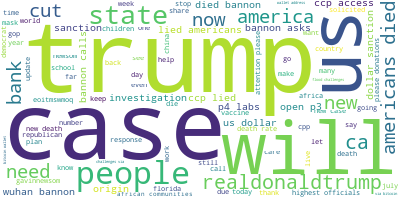

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(result['tweet_text_processed'].values))

#add stopwords from twitter and take out covid stuff we know the tweets are about covid
stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "california", "pandemic"] + list(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

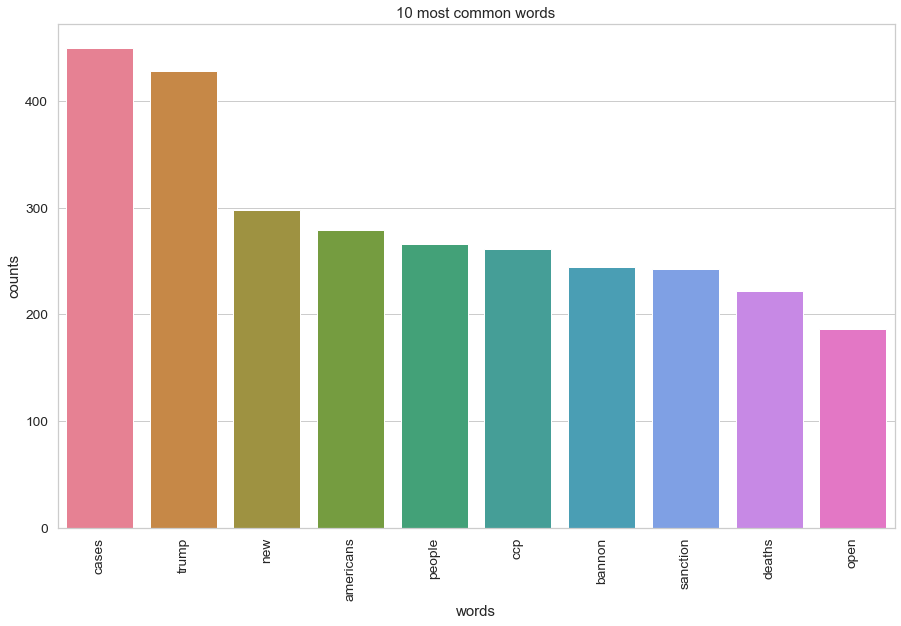

In [12]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words and same ones from wordcloud
my_additional_stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "covidー19", "california","pandemic","ca"]
count_vectorizer = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(result['tweet_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [13]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
cases new deaths gavinnewsom total school high year like people

Topic #1:
cases people deaths million flu new florida trump rate death

Topic #2:
care people just cases home newsom realdonaldtrump know church americans

Topic #3:
ccp bannon sanction americans open died officials cut access calls

Topic #4:
trump flood death just americans relief hope africa share communities


In [14]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

Wall time: 9.69 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.072087  0.086371       1        1  24.992501
4      0.057465 -0.165253       2        1  22.062006
0      0.058236  0.078535       3        1  19.024276
3     -0.221312  0.005161       4        1  17.584207
2      0.033525 -0.004814       5        1  16.337010, topic_info=            Term        Freq       Total Category  logprob  loglift
2731         ccp  200.000000  200.000000  Default  30.0000  30.0000
1851      bannon  187.000000  187.000000  Default  29.0000  29.0000
10491   sanction  185.000000  185.000000  Default  28.0000  28.0000
8630   officials  106.000000  106.000000  Default  27.0000  27.0000
7077        labs   97.000000   97.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
8311         new   19.748272  236.217618   Topic5  -6.0030  -0.6700
12039      trump   19.462587  341.985942   Topic5  -6.0176  -1.0545
11294       stop   15.099436   64.794196   Topic5  -6.2714   0.3552
8320        news   14.665878   83.111567   Topic5  -6.3006   0.0771
7282        like   14.520725   83.829432   Topic5  -6.3105   0.0585

[328 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
35         3  0.982654           096
72         1  0.965573          100k
130        3  0.963407         12000
140        1  0.199216            13
140        3  0.796864            13
...      ...       ...           ...
13235      1  0.403201          york
13235      3  0.489601          york
13235      5  0.115200          york
13316      2  0.983225  ziggystardad
13319      1  0.977512          zinc

[595 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 4, 3])